In [1]:
from tinyai import *

import pickle,gzip,math,os,time,shutil,random,logging,torch
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

import timm
import einops
from fastcore.foundation import L
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim,Tensor
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval import metrics

set_output()

In [2]:
from torcheval import metrics
from datasets import load_dataset_builder, load_dataset

In [3]:
xl, yl = 'img', 'label'
name = 'cifar10'

dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o)-0.5 for o in b[xl]]

bs = 32
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

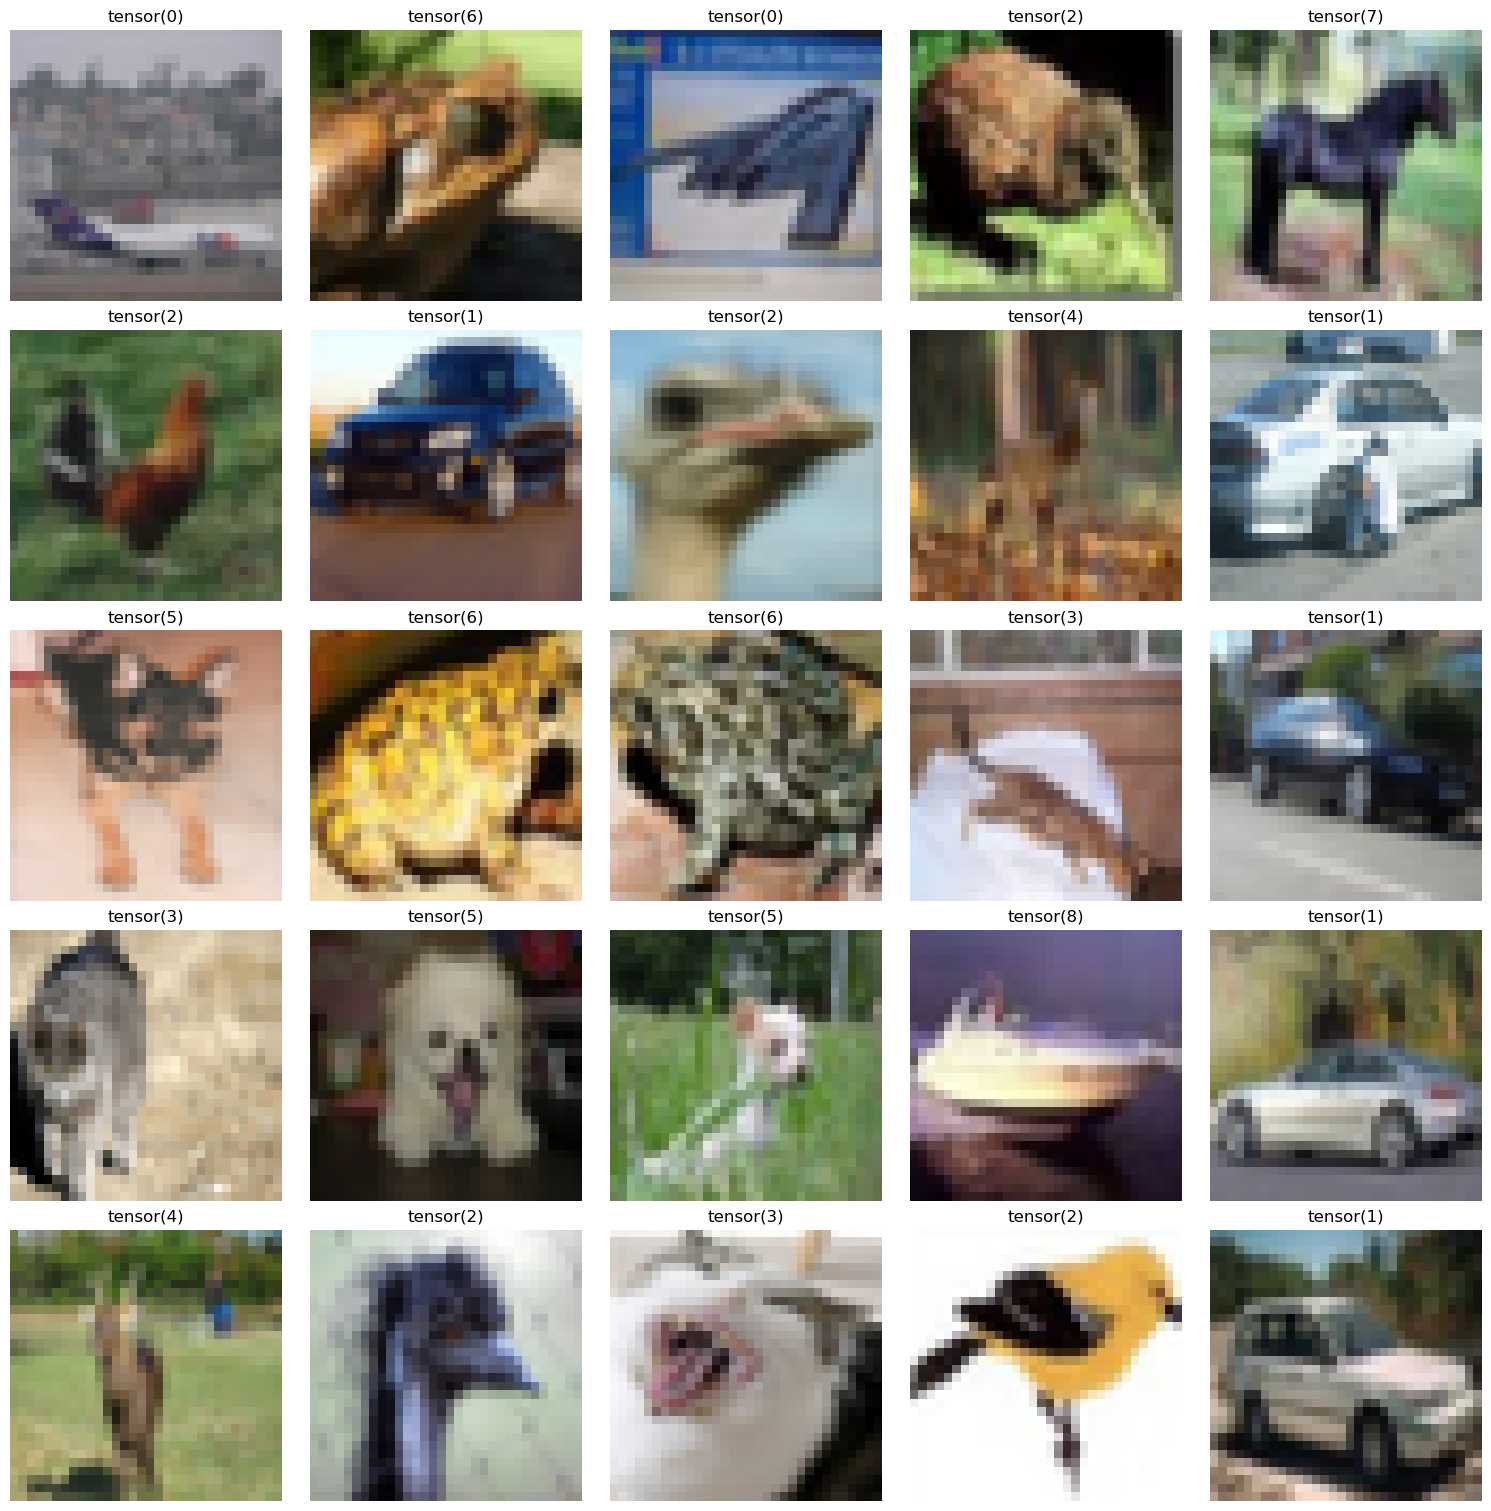

In [4]:
dt = dls.train
xb,yb = next(iter(dt))
show_images(xb[:25]+0.5, titles=[str(o) for o in yb[:25]])

In [5]:
from types import SimpleNamespace

def linear_sched(betamin=0.0001, betamax=0.02, nsteps=1000):
    beta = torch.linspace(betamin, betamax, nsteps)
    return SimpleNamespace(beta=beta, betamin=betamin, betamax=betamax, nsteps=nsteps, alpha=1.-beta, alphabar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [6]:
linsched = linear_sched(betamax=0.01)

In [ ]:
from tqdm.notebook import tqdm


nsteps = linsched.nsteps
def noisify(x0, alphabar):
    device = x0.device
    bs = len(x0)
    t = torch.randint(0, nsteps, (bs,), dtype=torch.long)
    epsilon = torch.randn(x0.shape, device=device)
    # expanding each alphabar_t to a single item in the batch
    alphabar_t = alphabar[t][:, None, None, None]

    # weighted average of original image and noise
    xt = x0 * alphabar_t.sqrt() + (1 - alphabar_t).sqrt() * epsilon

    # noised image, timestep : epsilon (noise target)
    return xt, t.to(device), epsilon


@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, nsteps):
    device = next(model.parameters()).device
    xt = torch.randn(sz, device=device)
    preds = []

    for t in tqdm(list(reversed(range(nsteps))), leave=False):
        # contains a batch of items at time T. Starts at max (e.g. 1000) which is noise
        t_batch = torch.full((sz[0],), t, device=device, dtype=torch.long)

        if t == 0:  # final step, add no noise, use the image
            z = torch.zeros_like(xt, device=device)
            alphabar_t1 = torch.tensor(1)
        else:
            z = torch.randn_like(xt)
            alphabar_t1 = alphabar[t - 1]

        alpha_t = alpha[t]
        alphabar_t = alphabar[t]
        beta_t = 1 - alpha_t
        betabar_t = 1 - alphabar_t
        betabar_t1 = 1 - alphabar_t1
        sigma_t = sigma[t]

        noise_pred = model(xt, t_batch)  # previous image

        # attempting to completely remove the noise
        x0_hat = ( (xt - betabar_t.sqrt() * noise_pred) / alphabar_t.sqrt() ).clamp(-1, 1)

        # how much we keep of the estimated noise
        x0_coeff = alphabar_t1.sqrt() * beta_t / betabar_t

        # how much we keep of the previous image
        xt_ceoff = alpha_t.sqrt() * betabar_t1 / betabar_t

        added_noise = sigma_t * z

        # weighted average of the previous image and the estimated noise + added noise
        xt = x0_hat * x0_coeff + xt * xt_ceoff + added_noise

        # as we converge on t=0, our prediction of x0 will be more accurate,
        # so we weight x0_coeff and less xt_coeff

        preds.append(to_cpu(xt))
    return preds

xt, t, epslilon = noisify(xb, linsched.alphabar)
t

tensor([166, 948, 632, 770, 801, 309, 928, 628, 966, 369, 877, 234, 823, 811,   0, 855,  20, 814, 704, 702,  20, 675, 320, 416, 574, 834,
        441, 444, 751, 736, 516, 802])

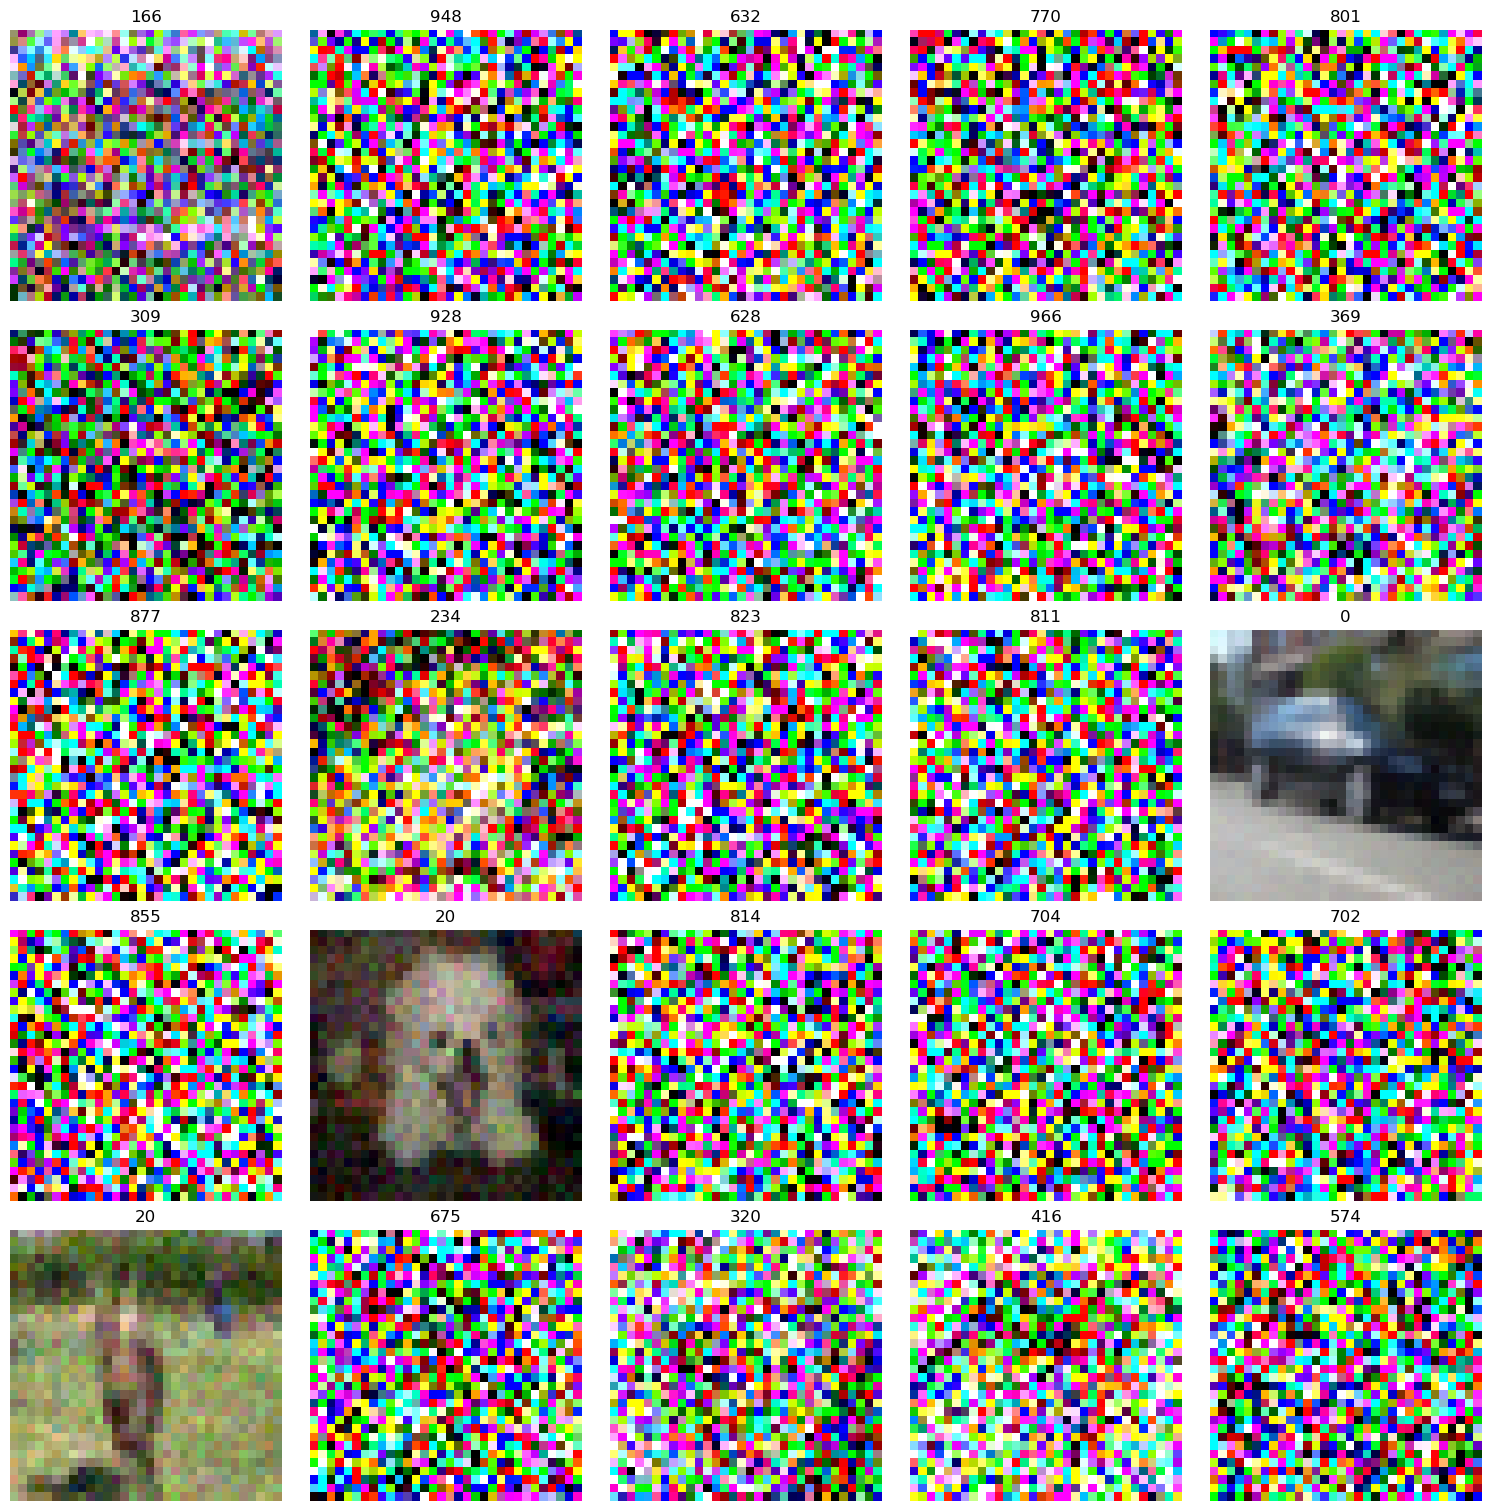

In [8]:
dt = dls.train
xb,yb = next(iter(dt))
show_images(xt[:25].clip(-0.5, 0.5) + 0.5, titles=t[:25].tolist())

In [9]:
from diffusers import UNet2DModel

class UNet(UNet2DModel):
    def forward(self, xb, t):
        return super().forward(xb, t).sample # type: ignore

def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
        for p in fc.L(o.downsamplers):
            init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

def collate_ddpm(b):
    return noisify(default_collate(b)[xl], linsched.alphabar)

def dl_ddpm(ds, bs):
    return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=16, pin_memory=True)


In [10]:
dls = DataLoaders(dl_ddpm(tds['train'], bs), dl_ddpm(tds['test'], bs))
model = UNet(in_channels=3, out_channels=3, block_out_channels=(32,64,128,256), norm_num_groups=8)
init_ddpm(model)

sum(p.numel() for p in model.parameters())

15891907

In [11]:
learn = Trainer(model, dls, F.mse_loss, cbs=PlotLossCB(plot_every=100))
learn.cbs[1] = AccelerateCB(n_inp=2)

In [37]:
import wandb


class WandBRecorder(Callback):
    order = 100

    def __init__(self, project, config):
        self.project, self.config = project, config

    def before_fit(self, learn):
        wandb.init(project=self.project, config=self.config)

    def cleanup_fit(self, learn):
        wandb.finish()

    def after_batch(self, learn):
        if learn.training:
            wandb.log({"train/loss": learn.loss.item()})
    
    def before_epoch(self, learn):
        if learn.training:
            wandb.log({"epoch": learn.epoch})

    def after_epoch(self, learn):
        if not learn.training:
            wandb.log({"val/loss": learn.epoch_loss.compute().item()})

        # try to log metrics
        # if hasattr(learn, "metrics"):
        #     log = learn.metrics._create_log(learn)
        #     prefix = 'train' if learn.training else 'val'
        #     for k, v in log.items():
        #         if k not in ["epoch", "train", "loss"]:
        #             try:
        #                 v = float(v)
        #             except ValueError:
        #                 pass
        #             wandb.log({f"{prefix}/{k}": v})
        #             print(f"{prefix}/{k}: {v}")

In [38]:
def sample_figure(learn):
    with torch.inference_mode():
        samples = sample(learn.model, (16, 3, 32, 32), linsched.alpha, linsched.alphabar, linsched.sig, linsched.nsteps)
    s = samples[-1].clamp(-0.5, 0.5) + 0.5
    plt.clf()
    fig, axs = get_grid(16)
    for im,ax in zip(s[:16], axs.flat): show_image(im, ax=ax)
    return fig

class WandBCBSamples(WandBRecorder):
    def after_epoch(self, learn):
        super().after_epoch(learn)
        fig = sample_figure(learn)
        wandb.log({"epoch": learn.epoch, "samples": wandb.Image(fig, caption=f"Epoch {learn.epoch}")})
        plt.close(fig)

In [39]:
dls = DataLoaders(dl_ddpm(tds['train'], bs), dl_ddpm(tds['test'], bs))
model = UNet(in_channels=3, out_channels=3, block_out_channels=(32,64,128,256), norm_num_groups=8)
init_ddpm(model)

learn = Trainer(model, dls, F.mse_loss)
learn.cbs[1] = AccelerateCB(n_inp=2)

In [40]:
epochs = 5
lr = 1e-3
learn.fit_one_cycle(epochs, lr=lr, cbs=WandBCBSamples(project='ddpm_cifar10', config={"epochs": epochs, "lr": lr, "sched": "onecycle", "comments": "lesson 21 wandb logging"}))

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/1563 [00:00<?, ?it/s]

   epoch    train     loss
       0    train   0.1859
       0     eval   0.0330
       1    train   0.0303
       1     eval   0.0289
       2    train   0.0276
       2     eval   0.0280
       3    train   0.0262
       3     eval   0.0251
       4    train   0.0255
       4     eval   0.0253


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▃▃▃▅▅▅▆▆▆███
train/loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,█▄▄▁▁
epoch,4
train/loss,0.03111
val/loss,0.0253


<Figure size 640x480 with 0 Axes>